
https://www.kaggle.com/ambarish/retinal-oct-image-analysis/data

https://www.kaggle.com/paultimothymooney/kermany2018/kernels



https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
from PIL import Image
import zlib
import itertools
import csv
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import skimage
from skimage import transform
from skimage.transform import resize
import scipy
from scipy.misc import imresize, imread
from scipy import misc
import keras
from keras import backend as K
from keras import models, layers, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Dropout, Input, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Lambda, AveragePooling2D
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.utils import class_weight

from skimage.color import rgb2gray
%matplotlib inline

Using TensorFlow backend.


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('Dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

import os
os.chdir('/content')

In [4]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("Dataset"))

# Any results you write to the current directory are saved as output.

['test', 'val', 'train']


In [5]:
listdir('Dataset/val')
listdir('Dataset/test')
listdir('Dataset/train')

['CNV', 'DRUSEN', 'DME', 'NORMAL']

In [0]:
val_path = 'Dataset/val/'
test_path = 'Dataset/test/'
train_path = 'Dataset/train/'

In [7]:
listdir(train_path + 'NORMAL')[0:10]

['NORMAL-777736-3.jpeg',
 'NORMAL-3988014-9.jpeg',
 'NORMAL-2226488-5.jpeg',
 'NORMAL-4677727-1.jpeg',
 'NORMAL-69123-10.jpeg',
 'NORMAL-6431481-3.jpeg',
 'NORMAL-3833491-4.jpeg',
 'NORMAL-3833528-8.jpeg',
 'NORMAL-2075832-12.jpeg',
 'NORMAL-6601359-4.jpeg']

In [0]:
train_normal_image = cv2.imread(train_path + 'NORMAL/NORMAL-1027133-2.jpeg')

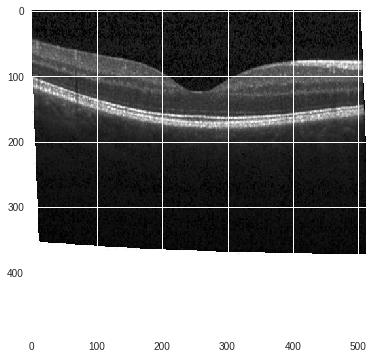

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(train_normal_image)

Load Images

In [0]:
imageSize =300
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                                      #,cv2.IMREAD_GRAYSCALE)
                if img_file is not None:
                    #img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    #, anti_aliasing=True) # anti_aliasing Gaussian smoothing to avoid aliasing artifacts
                    img_arr = np.asarray(img_file)
                    #grayscale = rgb2gray(img_file) # convert to grayscale
                    X.append(img_arr) #X.append(grayscale)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


# Load data

# Load Train, Test and Validation Data

In [11]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x_test_features, y_test_label_target, shuffle = 'True' , test_size=0.2) 
X_train,y_train=get_data(train_path)
X_test,y_test=get_data(test_path)
#X_val,y_val=get_data(val_path)

  0%|          | 0/700 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 301/301 [00:09<00:00, 32.45it/s]


In [0]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
#y_valHot = to_categorical(y_val, num_classes = 4)

In [13]:
y_testHot[0:10]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

# Build the Convolutional Network

In [14]:
# use pre trained model
pretrained_model_1 = VGG16(include_top=False, input_shape=(imageSize, imageSize, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
base_model = pretrained_model_1 # Topless
optimizer1 = keras.optimizers.Adam()
# Add top layer
x = base_model.output
x = Conv2D(300, kernel_size = (3,3), padding = 'valid')(x)
x = Flatten()(x)
x = Dropout(0.75)(x)
predictions = Dense(4, activation='softmax')(x)



model_cnn1 = Model(inputs=base_model.input, outputs=predictions)
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
    
model_cnn1.compile(loss='categorical_crossentropy', 
              optimizer=optimizer1, 
              metrics=['accuracy'])

# prints summary of the model
model_cnn1.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
___________________________

In [17]:
history = model_cnn1.fit(X_train,y_trainHot, 
                        epochs=100, 
                        batch_size = 100,
                        validation_data=(X_test,y_testHot), 
                        verbose=1)



#y_pred = classifier.fit(X_train, y_train).predict(X_test)

Instructions for updating:
Use tf.cast instead.
Train on 2800 samples, validate on 1200 samples
Epoch 1/100
2800/2800 [==============================] - 91s 33ms/step - loss: 3.2755 - acc: 0.5304 - val_loss: 0.6136 - val_acc: 0.7758
Epoch 2/100
2800/2800 [==============================] - 75s 27ms/step - loss: 0.4101 - acc: 0.8521 - val_loss: 0.3796 - val_acc: 0.8642
Epoch 3/100
2800/2800 [==============================] - 75s 27ms/step - loss: 0.2259 - acc: 0.9221 - val_loss: 0.3036 - val_acc: 0.8900
Epoch 4/100
2800/2800 [==============================] - 75s 27ms/step - loss: 0.1705 - acc: 0.9404 - val_loss: 0.3301 - val_acc: 0.8883
Epoch 5/100
2800/2800 [==============================] - 75s 27ms/step - loss: 0.1651 - acc: 0.9418 - val_loss: 0.2652 - val_acc: 0.9083
Epoch 6/100
2800/2800 [==============================] - 76s 27ms/step - loss: 0.1315 - acc: 0.9539 - val_loss: 0.2467 - val_acc: 0.9192
Epoch 7/100
2800/2800 [==============================] - 75s 27ms/step - loss: 0.1

# Loss and Accuracy graph

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


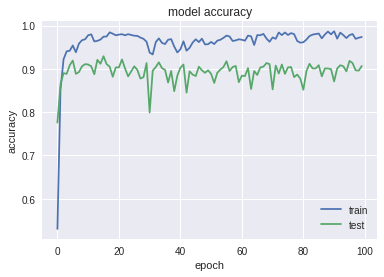

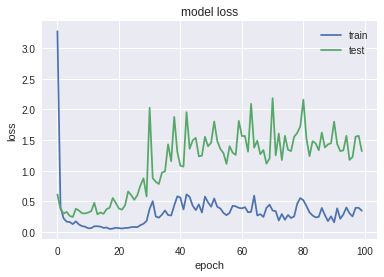

<Figure size 432x288 with 0 Axes>

In [18]:
"""
A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
as well as validation loss values and validation metrics values (if applicable).

"""
# list all data in history
print(history.history.keys())


# summarize history for accuracy
#plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig('./model_accuracy.png')


# summarize history for loss
#plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig('./model_loss.png')

# Save Model

Save/Load the Entire Model

This single HDF5 file will contain:

the architecture of the model (allowing the recreation of the model)
the weights of the model
the training configuration (e.g. loss, optimizer)
the state of the optimizer (allows you to resume the training from exactly where you left off)

In [0]:
from keras.models import load_model

# Deletes the existing model
#del model
# Creates a HDF5 file 'my_model.h5'
model_cnn1.save('my_model.h5')



# Check model on test images

# Model Evaluation

In [20]:
predicts=model_cnn1.predict(X_test,
          batch_size=1,
          verbose=1)
y_test_non_category = [ np.argmax(t) for t in y_testHot ]
y_predict = [ np.argmax(t) for t in predicts ]

# Evaluate on the test data

score = model_cnn1.evaluate(X_test, y_testHot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


1200/1200 [==============================] - 54s 45ms/step
Test loss: 1.3206121674948386
Test accuracy: 0.9066666666666666


# Function to plot confusion, Precision and Recall Matrix

In [0]:
#https://www.kaggle.com/shrikantds/retina-oct-inception-model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) 
    B =(C/C.sum(axis=0))
    labels = ["0-NORMAL","1-CNV","2-DME","3-DRUSEN"]
    
    font = {'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}
    matplotlib.rc('font', **font)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Plotting Confusion, Precision and Recall Matrix, Classification Report

-- Evaluate --
Confusion Matrix
[[290   0   9   1]
 [  1 249  24  26]
 [  4   2 287   7]
 [ 12   4  22 262]]
-------------------- Confusion matrix --------------------


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


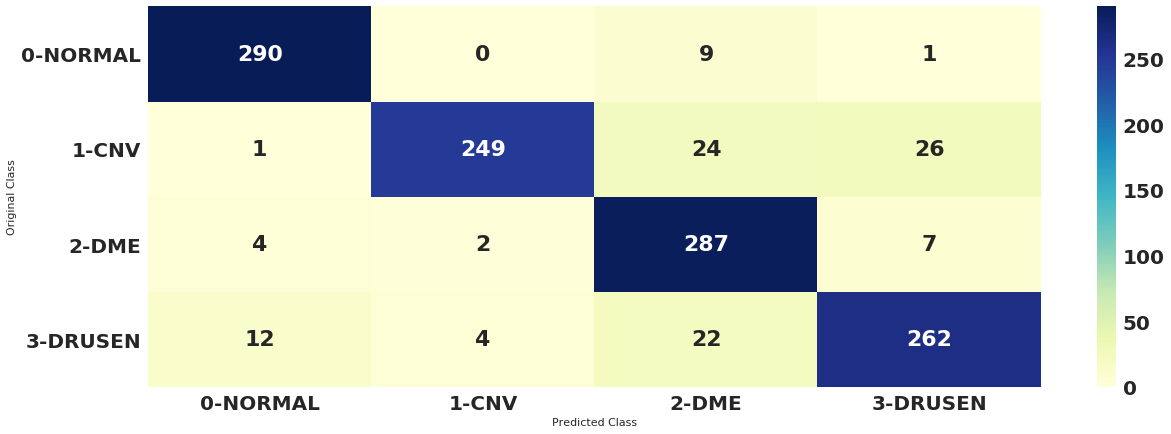

-------------------- Precision matrix (Columm Sum=1) --------------------


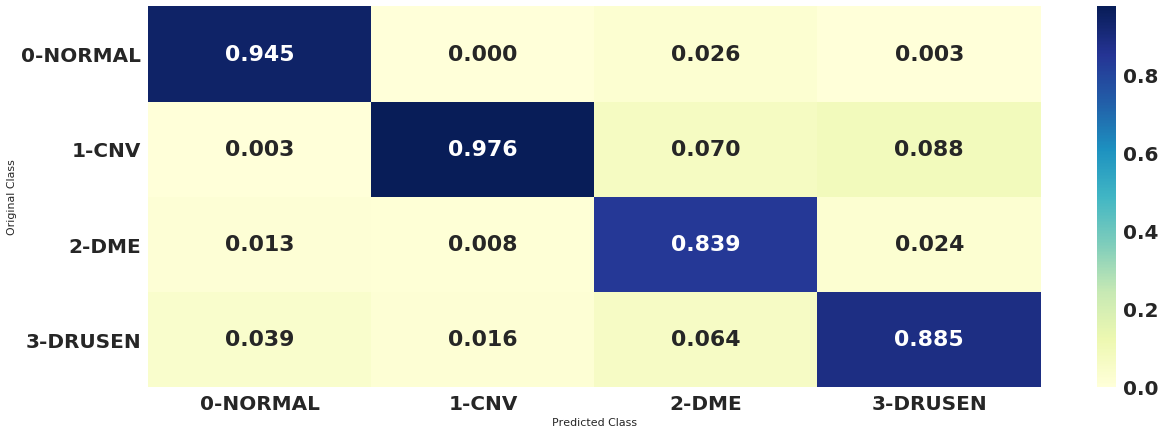

-------------------- Recall matrix (Row sum=1) --------------------


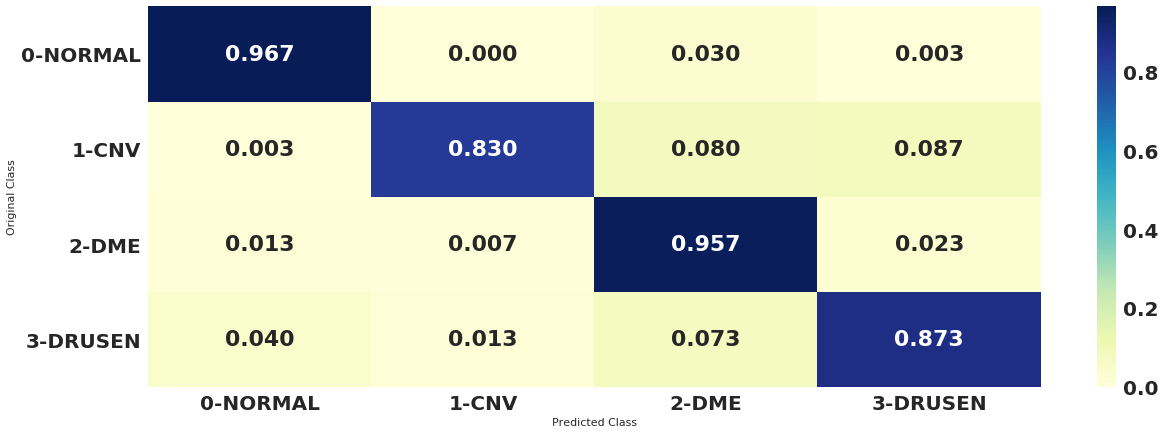

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       300
           1       0.98      0.83      0.90       300
           2       0.84      0.96      0.89       300
           3       0.89      0.87      0.88       300

   micro avg       0.91      0.91      0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("-- Evaluate --")
#output1 = np.argmax(predicts,axis=1)
#yTest=np.argmax(y_test)

print('Confusion Matrix')
cm1 = confusion_matrix(y_test_non_category, y_predict)
print(cm1)
plot_confusion_matrix(y_test_non_category, y_predict)

print('Classification Report')
target_names = ['0', '1','2','3']
print(classification_report(y_test_non_category,y_predict, target_names=target_names))
